# Group Comparison Analysis: Study Habits and Exam Performance
## T-tests, ANOVA, and Chi-Squared Tests

This notebook explores exam score differences across groups using:
- **T-tests**: Comparing exam scores between two groups
- **ANOVA**: Comparing exam scores across three or more groups
- **Chi-squared tests**: Examining associations between categorical variables

### Research Questions:
1. Do students with high study hours score higher on exams than students with low study hours?
2. Do students with good mental health score higher on exams than students with poor mental health?
3. Does exam performance differ across multiple study hour categories?
4. Does exam performance differ across multiple mental health categories?
5. Does exam performance differ across exercise frequency levels?
6. Does exam performance differ across netflix viewing time categories?
7. Does exam performance differ across diet quality levels?
8. Is exam performance associated with parental education level?
9. Is exam performance associated with diet quality?

### Statistical Methods:
- Independent samples t-test
- One-way ANOVA
- Post-hoc tests (Tukey HSD)
- Effect size measures (Cohen's d, eta-squared)
- Chi-squared test of independence
- Cramér's V effect size

In [387]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind, f_oneway, shapiro, levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Data Loading and Preparation

In [388]:
# Load the dataset
df = pd.read_csv('/Users/jje/src/Stats500FinalProject/data/student_habits_performance.csv', keep_default_na=False)

print(f"Dataset shape: {df.shape}")
print(f"Variables of interest:")
print(df[['study_hours_per_day', 'mental_health_rating', 'exam_score']].describe())

Dataset shape: (1000, 16)
Variables of interest:
       study_hours_per_day  mental_health_rating   exam_score
count           1000.00000           1000.000000  1000.000000
mean               3.55010              5.438000    69.601500
std                1.46889              2.847501    16.888564
min                0.00000              1.000000    18.400000
25%                2.60000              3.000000    58.475000
50%                3.50000              5.000000    70.500000
75%                4.50000              8.000000    81.325000
max                8.30000             10.000000   100.000000


## 2. Creating Group Categories

We'll create categorical groups based on continuous variables for group comparisons.

In [389]:
# Create study hours groups (2 groups for t-test)
studyMedian = df['study_hours_per_day'].median()
df['studyGroup2'] = df['study_hours_per_day'].apply(
    lambda x: 'Low Study Hours' if x < studyMedian else 'High Study Hours'
)

# Create study hours groups (3 groups for ANOVA)
studyQ1 = df['study_hours_per_day'].quantile(0.33)
studyQ2 = df['study_hours_per_day'].quantile(0.67)
df['studyGroup3'] = df['study_hours_per_day'].apply(
    lambda x: 'Low' if x < studyQ1 else ('Medium' if x < studyQ2 else 'High')
)

# Create mental health groups (2 groups for t-test)
mentalMedian = df['mental_health_rating'].median()
df['mentalGroup2'] = df['mental_health_rating'].apply(
    lambda x: 'Lower Mental Health' if x < mentalMedian else 'Higher Mental Health'
)

# Create mental health groups (3 groups for ANOVA)
mentalQ1 = df['mental_health_rating'].quantile(0.33)
mentalQ2 = df['mental_health_rating'].quantile(0.67)
df['mentalGroup3'] = df['mental_health_rating'].apply(
    lambda x: 'Low' if x < mentalQ1 else ('Medium' if x < mentalQ2 else 'High')
)

# Create exercise frequency groups (3 groups for ANOVA)
exerciseQ1 = df['exercise_frequency'].quantile(0.33)
exerciseQ2 = df['exercise_frequency'].quantile(0.67)
df['exerciseGroup3'] = df['exercise_frequency'].apply(
    lambda x: 'Low' if x < exerciseQ1 else ('Medium' if x < exerciseQ2 else 'High')
)

# Create netflix hours groups (3 groups for ANOVA)
netflixQ1 = df['netflix_hours'].quantile(0.33)
netflixQ2 = df['netflix_hours'].quantile(0.67)
df['netflixGroup3'] = df['netflix_hours'].apply(
    lambda x: 'Low' if x < netflixQ1 else ('Medium' if x < netflixQ2 else 'High')
)

# diet_quality is already categorical, so no grouping needed

print(f"Group Distribution - Study Hours (2 groups): {df['studyGroup2'].value_counts()}")
print(f"Group Distribution - Study Hours (3 groups): {df['studyGroup3'].value_counts()}")
print(f"Group Distribution - Mental Health (2 groups): {df['mentalGroup2'].value_counts()}")
print(f"Group Distribution - Mental Health (3 groups): {df['mentalGroup3'].value_counts()}")
print(f"Group Distribution - Exercise Frequency (3 groups): {df['exerciseGroup3'].value_counts()}")
print(f"Group Distribution - Netflix Hours (3 groups): {df['netflixGroup3'].value_counts()}")
print(f"Group Distribution - Diet Quality (categorical): {df['diet_quality'].value_counts()}")

Group Distribution - Study Hours (2 groups): studyGroup2
High Study Hours    529
Low Study Hours     471
Name: count, dtype: int64
Group Distribution - Study Hours (3 groups): studyGroup3
Medium    347
High      339
Low       314
Name: count, dtype: int64
Group Distribution - Mental Health (2 groups): mentalGroup2
Higher Mental Health    589
Lower Mental Health     411
Name: count, dtype: int64
Group Distribution - Mental Health (3 groups): mentalGroup3
High      382
Medium    317
Low       301
Name: count, dtype: int64
Group Distribution - Exercise Frequency (3 groups): exerciseGroup3
High      435
Low       290
Medium    275
Name: count, dtype: int64
Group Distribution - Netflix Hours (3 groups): netflixGroup3
High      342
Medium    339
Low       319
Name: count, dtype: int64
Group Distribution - Diet Quality (categorical): diet_quality
Fair    437
Good    378
Poor    185
Name: count, dtype: int64


## 3. T-Test Analysis (2 Groups)

### 3.1 Study Hours Groups: Independent Samples T-Test

**Hypotheses:**
- H₀: Mean exam scores are equal between low and high study hour groups
- H₁: Mean exam scores differ between low and high study hour groups

In [390]:
# Separate groups
lowStudyScores = df[df['studyGroup2'] == 'Low Study Hours']['exam_score']
highStudyScores = df[df['studyGroup2'] == 'High Study Hours']['exam_score']

# Descriptive statistics
print("Descriptive Statistics by Study Hours Group:")
print(f"Low Study Hours (n={len(lowStudyScores)}):")
print(f"Mean: {lowStudyScores.mean():.2f}")
print(f"SD: {lowStudyScores.std():.2f}")
print(f"Median: {lowStudyScores.median():.2f}")

print(f"High Study Hours (n={len(highStudyScores)}):")
print(f"Mean: {highStudyScores.mean():.2f}")
print(f"SD: {highStudyScores.std():.2f}")
print(f"Median: {highStudyScores.median():.2f}")

print(f"Mean Difference: {highStudyScores.mean() - lowStudyScores.mean():.2f} points")

Descriptive Statistics by Study Hours Group:
Low Study Hours (n=471):
Mean: 57.81
SD: 13.28
Median: 58.40
High Study Hours (n=529):
Mean: 80.10
SD: 12.17
Median: 79.60
Mean Difference: 22.30 points


In [391]:
# 1. Normality test
statLow, pLow = shapiro(lowStudyScores)
statHigh, pHigh = shapiro(highStudyScores)

print("1. Normality (Shapiro-Wilk test):")
print(f"Low Study Hours: p = {pLow:.4f} {'(Normal)' if pLow > 0.05 else '(Not Normal)'}")
print(f"High Study Hours: p = {pHigh:.4f} {'(Normal)' if pHigh > 0.05 else '(Not Normal)'}")

# 2. Homogeneity of variance
statLevene, pLevene = levene(lowStudyScores, highStudyScores)
print(f"2. Homogeneity of Variance (Levene's test):")
print(f"p = {pLevene:.4f} {'(Equal variances)' if pLevene > 0.05 else '(Unequal variances)'}")

1. Normality (Shapiro-Wilk test):
Low Study Hours: p = 0.1422 (Normal)
High Study Hours: p = 0.0000 (Not Normal)
2. Homogeneity of Variance (Levene's test):
p = 0.1378 (Equal variances)


In [392]:
# Perform t-test
tStat, pValue = ttest_ind(highStudyScores, lowStudyScores, equal_var=(pLevene > 0.05))

print("Independent Samples T-Test Results:")
print(f"t-statistic: {tStat:.4f}")
print(f"p-value: {pValue:.4e}")
print(f"Significance: {'Significant' if pValue < 0.05 else 'Not Significant'} at α = 0.05")

# Calculate Cohen's d (effect size)
pooledStd = np.sqrt(((len(lowStudyScores)-1)*lowStudyScores.std()**2 + 
                      (len(highStudyScores)-1)*highStudyScores.std()**2) / 
                     (len(lowStudyScores) + len(highStudyScores) - 2))
cohensD = (highStudyScores.mean() - lowStudyScores.mean()) / pooledStd

print(f"Effect Size (Cohen's d): {cohensD:.4f}")
if abs(cohensD) < 0.2:
    effect = "negligible"
elif abs(cohensD) < 0.5:
    effect = "small"
elif abs(cohensD) < 0.8:
    effect = "medium"
else:
    effect = "large"
print(f"Interpretation: {effect.capitalize()} effect")

Independent Samples T-Test Results:
t-statistic: 27.7087
p-value: 8.4759e-126
Significance: Significant at α = 0.05
Effect Size (Cohen's d): 1.7554
Interpretation: Large effect


### 3.2 Mental Health Groups: Independent Samples T-Test

**Hypotheses:**
- H₀: Mean exam scores are equal between lower and higher mental health groups
- H₁: Mean exam scores differ between lower and higher mental health groups

In [393]:
# Separate groups
lowerMentalScores = df[df['mentalGroup2'] == 'Lower Mental Health']['exam_score']
higherMentalScores = df[df['mentalGroup2'] == 'Higher Mental Health']['exam_score']

# Descriptive statistics
print("Descriptive Statistics by Mental Health Group:")
print(f"Lower Mental Health (n={len(lowerMentalScores)}):")
print(f"Mean: {lowerMentalScores.mean():.2f}")
print(f"SD: {lowerMentalScores.std():.2f}")
print(f"Median: {lowerMentalScores.median():.2f}")

print(f"Higher Mental Health (n={len(higherMentalScores)}):")
print(f"Mean: {higherMentalScores.mean():.2f}")
print(f"SD: {higherMentalScores.std():.2f}")
print(f"Median: {higherMentalScores.median():.2f}")

print(f"Mean Difference: {higherMentalScores.mean() - lowerMentalScores.mean():.2f} points")

Descriptive Statistics by Mental Health Group:
Lower Mental Health (n=411):
Mean: 64.03
SD: 16.39
Median: 64.20
Higher Mental Health (n=589):
Mean: 73.49
SD: 16.14
Median: 74.00
Mean Difference: 9.45 points


In [394]:
# Check assumptions

# 1. Normality test
statLow, pLow = shapiro(lowerMentalScores)
statHigh, pHigh = shapiro(higherMentalScores)

print("1. Normality (Shapiro-Wilk test):")
print(f"Lower Mental Health: p = {pLow:.4f} {'(Normal)' if pLow > 0.05 else '(Not Normal)'}")
print(f"Higher Mental Health: p = {pHigh:.4f} {'(Normal)' if pHigh > 0.05 else '(Not Normal)'}")

# 2. Homogeneity of variance
statLevene, pLevene = levene(lowerMentalScores, higherMentalScores)
print(f"2. Homogeneity of Variance (Levene's test):")
print(f"p = {pLevene:.4f} {'(Equal variances)' if pLevene > 0.05 else '(Unequal variances)'}")

1. Normality (Shapiro-Wilk test):
Lower Mental Health: p = 0.0834 (Normal)
Higher Mental Health: p = 0.0000 (Not Normal)
2. Homogeneity of Variance (Levene's test):
p = 0.9070 (Equal variances)


In [395]:
# Perform t-test
tStat, pValue = ttest_ind(higherMentalScores, lowerMentalScores, equal_var=(pLevene > 0.05))

print("Independent Samples T-Test Results:")
print(f"t-statistic: {tStat:.4f}")
print(f"p-value: {pValue:.4e}")
print(f"Significance: {'Significant' if pValue < 0.05 else 'Not Significant'} at α = 0.05")

# Calculate Cohen's d (effect size)
pooledStd = np.sqrt(((len(lowerMentalScores)-1)*lowerMentalScores.std()**2 + 
                      (len(higherMentalScores)-1)*higherMentalScores.std()**2) / 
                     (len(lowerMentalScores) + len(higherMentalScores) - 2))
cohensD = (higherMentalScores.mean() - lowerMentalScores.mean()) / pooledStd

print(f"Effect Size (Cohen's d): {cohensD:.4f}")
if abs(cohensD) < 0.2:
    effect = "negligible"
elif abs(cohensD) < 0.5:
    effect = "small"
elif abs(cohensD) < 0.8:
    effect = "medium"
else:
    effect = "large"
print(f"Interpretation: {effect.capitalize()} effect")

Independent Samples T-Test Results:
t-statistic: 9.0529
p-value: 7.1393e-19
Significance: Significant at α = 0.05
Effect Size (Cohen's d): 0.5818
Interpretation: Medium effect


## 4. Visualization of T-Test Results

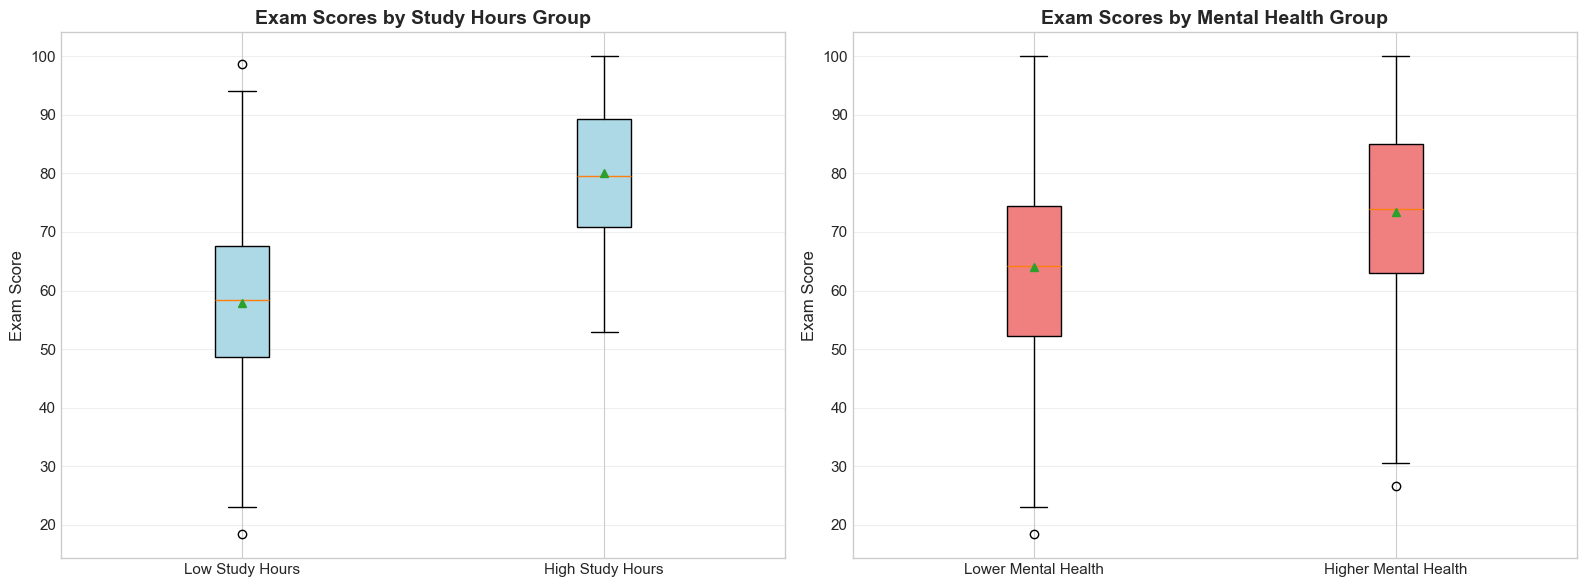

In [396]:
# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Study hours comparison
boxData1 = [lowStudyScores, highStudyScores]
bp1 = axes[0].boxplot(boxData1, labels=['Low Study Hours', 'High Study Hours'],
                       patch_artist=True, showmeans=True)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
axes[0].set_ylabel('Exam Score', fontsize=12)
axes[0].set_title('Exam Scores by Study Hours Group', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Mental health comparison
boxData2 = [lowerMentalScores, higherMentalScores]
bp2 = axes[1].boxplot(boxData2, labels=['Lower Mental Health', 'Higher Mental Health'],
                       patch_artist=True, showmeans=True)
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')
axes[1].set_ylabel('Exam Score', fontsize=12)
axes[1].set_title('Exam Scores by Mental Health Group', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. One-Way ANOVA (3+ Groups)

### 5.1 Study Hours Groups: One-Way ANOVA

**Hypotheses:**
- H₀: Mean exam scores are equal across all study hour groups (Low, Medium, High)
- H₁: At least one group mean differs from the others

In [397]:
# Separate groups
lowStudy = df[df['studyGroup3'] == 'Low']['exam_score']
medStudy = df[df['studyGroup3'] == 'Medium']['exam_score']
highStudy = df[df['studyGroup3'] == 'High']['exam_score']

# Descriptive statistics
print("Descriptive Statistics by Study Hours Group (3 levels):")
print(f"Low (n={len(lowStudy)}):")
print(f"Mean: {lowStudy.mean():.2f}, SD: {lowStudy.std():.2f}")
print(f"Medium (n={len(medStudy)}):")
print(f"Mean: {medStudy.mean():.2f}, SD: {medStudy.std():.2f}")
print(f"High (n={len(highStudy)}):")
print(f"Mean: {highStudy.mean():.2f}, SD: {highStudy.std():.2f}")

Descriptive Statistics by Study Hours Group (3 levels):
Low (n=314):
Mean: 53.45, SD: 12.40
Medium (n=347):
Mean: 69.64, SD: 10.15
High (n=339):
Mean: 84.52, SD: 11.38


In [398]:
# Check assumptions for ANOVA

# 1. Normality
_, pLow = shapiro(lowStudy)
_, pMed = shapiro(medStudy)
_, pHigh = shapiro(highStudy)
print("1. Normality (Shapiro-Wilk):")
print(f"Low: p = {pLow:.4f}")
print(f"Medium: p = {pMed:.4f}")
print(f"High: p = {pHigh:.4f}")

# 2. Homogeneity of variance
statLevene, pLevene = levene(lowStudy, medStudy, highStudy)
print(f"2. Homogeneity of Variance (Levene's test):")
print(f"p = {pLevene:.4f} {'(Equal variances)' if pLevene > 0.05 else '(Unequal variances)'}")

1. Normality (Shapiro-Wilk):
Low: p = 0.6678
Medium: p = 0.7494
High: p = 0.0000
2. Homogeneity of Variance (Levene's test):
p = 0.0003 (Unequal variances)


In [399]:
# Perform ANOVA
fStat, pValue = f_oneway(lowStudy, medStudy, highStudy)

print("One-Way ANOVA Results:")
print(f"F-statistic: {fStat:.4f}")
print(f"p-value: {pValue:.4e}")
print(f"Significance: {'Significant' if pValue < 0.05 else 'Not Significant'} at α = 0.05")

# Calculate eta-squared (effect size)
allScores = pd.concat([lowStudy, medStudy, highStudy])
ssTotal = np.sum((allScores - allScores.mean())**2)
ssBetween = (len(lowStudy) * (lowStudy.mean() - allScores.mean())**2 + 
             len(medStudy) * (medStudy.mean() - allScores.mean())**2 + 
             len(highStudy) * (highStudy.mean() - allScores.mean())**2)
etaSquared = ssBetween / ssTotal

print(f"Effect Size (η²): {etaSquared:.4f}")
if etaSquared < 0.01:
    effect = "negligible"
elif etaSquared < 0.06:
    effect = "small"
elif etaSquared < 0.14:
    effect = "medium"
else:
    effect = "large"
print(f"Interpretation: {effect.capitalize()} effect")

One-Way ANOVA Results:
F-statistic: 614.6671
p-value: 1.1905e-174
Significance: Significant at α = 0.05
Effect Size (η²): 0.5522
Interpretation: Large effect


In [400]:
# If ANOVA is Significant)
if pValue < 0.05:
    print("Post-Hoc Analysis (Tukey HSD):")
    
    # Prepare data for Tukey HSD
    studyData = df[['exam_score', 'studyGroup3']].copy()
    tukey = pairwise_tukeyhsd(endog=studyData['exam_score'], 
                               groups=studyData['studyGroup3'], 
                               alpha=0.05)
    
    print(tukey)
    
    print("Conclusion:")
    print("Exam scores differ Significantly across study hour groups.")
    print("See post-hoc results above for pairwise comparisons.")
else:
    print("Conclusion:")
    print("No Significant differences in exam scores across study hour groups.")

Post-Hoc Analysis (Tukey HSD):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
  High    Low -31.0675   0.0 -33.1473 -28.9877   True
  High Medium -14.8809   0.0 -16.9087  -12.853   True
   Low Medium  16.1866   0.0  14.1184  18.2549   True
-----------------------------------------------------
Conclusion:
Exam scores differ Significantly across study hour groups.
See post-hoc results above for pairwise comparisons.


### 5.2 Mental Health Groups: One-Way ANOVA

**Hypotheses:**
- H₀: Mean exam scores are equal across all mental health groups (Low, Medium, High)
- H₁: At least one group mean differs from the others

In [401]:
# Separate groups
lowMental = df[df['mentalGroup3'] == 'Low']['exam_score']
medMental = df[df['mentalGroup3'] == 'Medium']['exam_score']
highMental = df[df['mentalGroup3'] == 'High']['exam_score']

# Descriptive statistics
print("Descriptive Statistics by Mental Health Group (3 levels):")
print(f"Low (n={len(lowMental)}):")
print(f"Mean: {lowMental.mean():.2f}, SD: {lowMental.std():.2f}")
print(f"Medium (n={len(medMental)}):")
print(f"Mean: {medMental.mean():.2f}, SD: {medMental.std():.2f}")
print(f"High (n={len(highMental)}):")
print(f"Mean: {highMental.mean():.2f}, SD: {highMental.std():.2f}")

Descriptive Statistics by Mental Health Group (3 levels):
Low (n=301):
Mean: 63.43, SD: 15.94
Medium (n=317):
Mean: 67.87, SD: 16.85
High (n=382):
Mean: 75.90, SD: 15.49


In [402]:
# Check assumptions
print("Assumption Checks for ANOVA:")

# 1. Normality
_, pLow = shapiro(lowMental)
_, pMed = shapiro(medMental)
_, pHigh = shapiro(highMental)
print("Normality (Shapiro-Wilk):")
print(f"Low: p = {pLow:.4f}")
print(f"Medium: p = {pMed:.4f}")
print(f"High: p = {pHigh:.4f}")

# 2. Homogeneity of variance
statLevene, pLevene = levene(lowMental, medMental, highMental)
print(f"2. Homogeneity of Variance (Levene's test):")
print(f"p = {pLevene:.4f} {'(Equal variances)' if pLevene > 0.05 else '(Unequal variances)'}")

Assumption Checks for ANOVA:
Normality (Shapiro-Wilk):
Low: p = 0.0848
Medium: p = 0.0105
High: p = 0.0000
2. Homogeneity of Variance (Levene's test):
p = 0.2683 (Equal variances)


In [403]:
# Perform ANOVA
fStat, pValue = f_oneway(lowMental, medMental, highMental)

print("One-Way ANOVA Results:")
print(f"F-statistic: {fStat:.4f}")
print(f"p-value: {pValue:.4e}")
print(f"Significance: {'Significant' if pValue < 0.05 else 'Not Significant'} at α = 0.05")

# Calculate eta-squared (effect size)
allScores = pd.concat([lowMental, medMental, highMental])
ssTotal = np.sum((allScores - allScores.mean())**2)
ssBetween = (len(lowMental) * (lowMental.mean() - allScores.mean())**2 + 
             len(medMental) * (medMental.mean() - allScores.mean())**2 + 
             len(highMental) * (highMental.mean() - allScores.mean())**2)
etaSquared = ssBetween / ssTotal

print(f"\nEffect Size (η²): {etaSquared:.4f}")
if etaSquared < 0.01:
    effect = "negligible"
elif etaSquared < 0.06:
    effect = "small"
elif etaSquared < 0.14:
    effect = "medium"
else:
    effect = "large"
print(f"  Interpretation: {effect.capitalize()} effect")

One-Way ANOVA Results:
F-statistic: 53.4275
p-value: 9.0758e-23
Significance: Significant at α = 0.05

Effect Size (η²): 0.0968
  Interpretation: Medium effect


In [404]:
# Post-hoc test (if ANOVA is Significant)
if pValue < 0.05:
    print("\nPost-Hoc Analysis (Tukey HSD):")
    
    # Prepare data for Tukey HSD
    mentalData = df[['exam_score', 'mentalGroup3']].copy()
    tukey = pairwise_tukeyhsd(endog=mentalData['exam_score'], 
                               groups=mentalData['mentalGroup3'], 
                               alpha=0.05)
    
    print(tukey)
    
    print("Conclusion:")
    print("Exam scores differ Significantly across mental health groups.")
    print("See post-hoc results above for pairwise comparisons.")
else:
    print("Conclusion:")
    print("No Significant differences in exam scores across mental health groups.")


Post-Hoc Analysis (Tukey HSD):
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
  High    Low -12.4716    0.0 -15.3781 -9.5651   True
  High Medium  -8.0369    0.0 -10.9021 -5.1717   True
   Low Medium   4.4347 0.0018   1.3997  7.4696   True
-----------------------------------------------------
Conclusion:
Exam scores differ Significantly across mental health groups.
See post-hoc results above for pairwise comparisons.


### 5.3 Exercise Frequency Groups: One-Way ANOVA

**Hypotheses:**
- H₀: Mean exam scores are equal across all exercise frequency groups (Low, Medium, High)
- H₁: At least one group mean differs from the others

In [405]:
# Separate groups
lowExercise = df[df['exerciseGroup3'] == 'Low']['exam_score']
medExercise = df[df['exerciseGroup3'] == 'Medium']['exam_score']
highExercise = df[df['exerciseGroup3'] == 'High']['exam_score']

# Descriptive statistics
print("Descriptive Statistics by Exercise Frequency Group (3 levels):")
print(f"Low (n={len(lowExercise)}):")
print(f"Mean: {lowExercise.mean():.2f}, SD: {lowExercise.std():.2f}")
print(f"Medium (n={len(medExercise)}):")
print(f"Mean: {medExercise.mean():.2f}, SD: {medExercise.std():.2f}")
print(f"High (n={len(highExercise)}):")
print(f"Mean: {highExercise.mean():.2f}, SD: {highExercise.std():.2f}")

Descriptive Statistics by Exercise Frequency Group (3 levels):
Low (n=290):
Mean: 66.09, SD: 16.97
Medium (n=275):
Mean: 69.30, SD: 15.91
High (n=435):
Mean: 72.13, SD: 17.04


In [406]:
# Check assumptions
print("Assumption Checks for ANOVA:")

# 1. Normality
_, pLow = shapiro(lowExercise)
_, pMed = shapiro(medExercise)
_, pHigh = shapiro(highExercise)
print("Normality (Shapiro-Wilk):")
print(f"Low: p = {pLow:.4f}")
print(f"Medium: p = {pMed:.4f}")
print(f"High: p = {pHigh:.4f}")

# 2. Homogeneity of variance
statLevene, pLevene = levene(lowExercise, medExercise, highExercise)
print(f"2. Homogeneity of Variance (Levene's test):")
print(f"p = {pLevene:.4f} {'(Equal variances)' if pLevene > 0.05 else '(Unequal variances)'}")

Assumption Checks for ANOVA:
Normality (Shapiro-Wilk):
Low: p = 0.0264
Medium: p = 0.0301
High: p = 0.0000
2. Homogeneity of Variance (Levene's test):
p = 0.2589 (Equal variances)


In [407]:
# Perform ANOVA
fStat, pValue = f_oneway(lowExercise, medExercise, highExercise)

print("One-Way ANOVA Results:")
print(f"F-statistic: {fStat:.4f}")
print(f"p-value: {pValue:.4e}")
print(f"Significance: {'Significant' if pValue < 0.05 else 'Not Significant'} at α = 0.05")

# Calculate eta-squared (effect size)
allScores = pd.concat([lowExercise, medExercise, highExercise])
ssTotal = np.sum((allScores - allScores.mean())**2)
ssBetween = (len(lowExercise) * (lowExercise.mean() - allScores.mean())**2 + 
             len(medExercise) * (medExercise.mean() - allScores.mean())**2 + 
             len(highExercise) * (highExercise.mean() - allScores.mean())**2)
etaSquared = ssBetween / ssTotal

print(f"Effect Size (η²): {etaSquared:.4f}")
if etaSquared < 0.01:
    effect = "negligible"
elif etaSquared < 0.06:
    effect = "small"
elif etaSquared < 0.14:
    effect = "medium"
else:
    effect = "large"
print(f"Interpretation: {effect.capitalize()} effect")

One-Way ANOVA Results:
F-statistic: 11.4395
p-value: 1.2248e-05
Significance: Significant at α = 0.05
Effect Size (η²): 0.0224
Interpretation: Small effect


In [408]:
# Post-hoc test (if ANOVA is Significant)
if pValue < 0.05:
    print("Post-Hoc Analysis (Tukey HSD):")
    
    # Prepare data for Tukey HSD
    exerciseData = df[['exam_score', 'exerciseGroup3']].copy()
    tukey = pairwise_tukeyhsd(endog=exerciseData['exam_score'], 
                               groups=exerciseData['exerciseGroup3'], 
                               alpha=0.05)
    
    print(tukey)
    
    print("Conclusion:")
    print("Exam scores differ Significantly across exercise frequency groups.")
else:
    print("Conclusion:")
    print("No Significant differences in exam scores across exercise frequency groups.")

Post-Hoc Analysis (Tukey HSD):
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  High    Low  -6.0448    0.0 -9.0191 -3.0706   True
  High Medium  -2.8313 0.0719 -5.8538  0.1913  False
   Low Medium   3.2135 0.0585 -0.0887  6.5158  False
----------------------------------------------------
Conclusion:
Exam scores differ Significantly across exercise frequency groups.


### 5.4 Netflix Hours Groups: One-Way ANOVA

**Hypotheses:**
- H₀: Mean exam scores are equal across all netflix hours groups (Low, Medium, High)
- H₁: At least one group mean differs from the others

In [409]:
# Separate groups
lowNetflix = df[df['netflixGroup3'] == 'Low']['exam_score']
medNetflix = df[df['netflixGroup3'] == 'Medium']['exam_score']
highNetflix = df[df['netflixGroup3'] == 'High']['exam_score']

# Descriptive statistics
print("Descriptive Statistics by Netflix Hours Group (3 levels):")
print(f"Low (n={len(lowNetflix)}):")
print(f"Mean: {lowNetflix.mean():.2f}, SD: {lowNetflix.std():.2f}")
print(f"Medium (n={len(medNetflix)}):")
print(f"Mean: {medNetflix.mean():.2f}, SD: {medNetflix.std():.2f}")
print(f"High (n={len(highNetflix)}):")
print(f"Mean: {highNetflix.mean():.2f}, SD: {highNetflix.std():.2f}")

Descriptive Statistics by Netflix Hours Group (3 levels):
Low (n=319):
Mean: 73.14, SD: 15.93
Medium (n=339):
Mean: 69.40, SD: 16.61
High (n=342):
Mean: 66.51, SD: 17.45


In [410]:
# Check assumptions
print("Assumption Checks for ANOVA:")

# 1. Normality
_, pLow = shapiro(lowNetflix)
_, pMed = shapiro(medNetflix)
_, pHigh = shapiro(highNetflix)
print("Normality (Shapiro-Wilk):")
print(f"Low: p = {pLow:.4f}")
print(f"Medium: p = {pMed:.4f}")
print(f"High: p = {pHigh:.4f}")

# 2. Homogeneity of variance
statLevene, pLevene = levene(lowNetflix, medNetflix, highNetflix)
print(f"2. Homogeneity of Variance (Levene's test):")
print(f"p = {pLevene:.4f} {'(Equal variances)' if pLevene > 0.05 else '(Unequal variances)'}")

Assumption Checks for ANOVA:
Normality (Shapiro-Wilk):
Low: p = 0.0002
Medium: p = 0.0008
High: p = 0.0149
2. Homogeneity of Variance (Levene's test):
p = 0.1869 (Equal variances)


In [411]:
# Perform ANOVA
fStat, pValue = f_oneway(lowNetflix, medNetflix, highNetflix)

print("One-Way ANOVA Results:")
print(f"F-statistic: {fStat:.4f}")
print(f"p-value: {pValue:.4e}")
print(f"Significance: {'Significant' if pValue < 0.05 else 'Not Significant'} at α = 0.05")

# Calculate eta-squared (effect size)
allScores = pd.concat([lowNetflix, medNetflix, highNetflix])
ssTotal = np.sum((allScores - allScores.mean())**2)
ssBetween = (len(lowNetflix) * (lowNetflix.mean() - allScores.mean())**2 + 
             len(medNetflix) * (medNetflix.mean() - allScores.mean())**2 + 
             len(highNetflix) * (highNetflix.mean() - allScores.mean())**2)
etaSquared = ssBetween / ssTotal

print(f"Effect Size (η²): {etaSquared:.4f}")
if etaSquared < 0.01:
    effect = "negligible"
elif etaSquared < 0.06:
    effect = "small"
elif etaSquared < 0.14:
    effect = "medium"
else:
    effect = "large"
print(f"Interpretation: {effect.capitalize()} effect")

One-Way ANOVA Results:
F-statistic: 13.0730
p-value: 2.4867e-06
Significance: Significant at α = 0.05
Effect Size (η²): 0.0256
Interpretation: Small effect


In [412]:
# Post-hoc test (if ANOVA is Significant)
if pValue < 0.05:
    print("\nPost-Hoc Analysis (Tukey HSD):")
    
    # Prepare data for Tukey HSD
    netflixData = df[['exam_score', 'netflixGroup3']].copy()
    tukey = pairwise_tukeyhsd(endog=netflixData['exam_score'], 
                               groups=netflixData['netflixGroup3'], 
                               alpha=0.05)
    
    print(tukey)
    
    print("Conclusion:")
    print("Exam scores differ Significantly across netflix hours groups.")
else:
    print("Conclusion:")
    print("No Significant differences in exam scores across netflix hours groups.")


Post-Hoc Analysis (Tukey HSD):
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  High    Low   6.6321    0.0  3.5832  9.6811   True
  High Medium   2.8891 0.0622 -0.1129  5.8912  False
   Low Medium   -3.743 0.0115 -6.7984 -0.6875   True
----------------------------------------------------
Conclusion:
Exam scores differ Significantly across netflix hours groups.


### 5.5 Diet Quality Groups: One-Way ANOVA

**Hypotheses:**
- H₀: Mean exam scores are equal across all diet quality groups (Poor, Fair, Good)
- H₁: At least one group mean differs from the others

In [413]:
# Separate groups (diet_quality is already categorical)
poorDiet = df[df['diet_quality'] == 'Poor']['exam_score']
fairDiet = df[df['diet_quality'] == 'Fair']['exam_score']
goodDiet = df[df['diet_quality'] == 'Good']['exam_score']

# Descriptive statistics
print("Descriptive Statistics by Diet Quality Group:")
print(f"Poor (n={len(poorDiet)}):")
print(f"Mean: {poorDiet.mean():.2f}, SD: {poorDiet.std():.2f}")
print(f"Fair (n={len(fairDiet)}):")
print(f"Mean: {fairDiet.mean():.2f}, SD: {fairDiet.std():.2f}")
print(f"Good (n={len(goodDiet)}):")
print(f"Mean: {goodDiet.mean():.2f}, SD: {goodDiet.std():.2f}")

Descriptive Statistics by Diet Quality Group:
Poor (n=185):
Mean: 68.13, SD: 17.06
Fair (n=437):
Mean: 70.43, SD: 16.65
Good (n=378):
Mean: 69.37, SD: 17.07


In [414]:
# Check assumptions
print("Assumption Checks for ANOVA:")

# 1. Normality
_, pPoor = shapiro(poorDiet)
_, pFair = shapiro(fairDiet)
_, pGood = shapiro(goodDiet)
print("Normality (Shapiro-Wilk):")
print(f"Poor: p = {pPoor:.4f}")
print(f"Fair: p = {pFair:.4f}")
print(f"Good: p = {pGood:.4f}\n")

# 2. Homogeneity of variance
statLevene, pLevene = levene(poorDiet, fairDiet, goodDiet)
print(f"2. Homogeneity of Variance (Levene's test):")
print(f"p = {pLevene:.4f} {'(Equal variances)' if pLevene > 0.05 else '(Unequal variances})'}")

Assumption Checks for ANOVA:
Normality (Shapiro-Wilk):
Poor: p = 0.0332
Fair: p = 0.0002
Good: p = 0.0012

2. Homogeneity of Variance (Levene's test):
p = 0.8866 (Equal variances)


In [415]:
# Perform ANOVA
fStat, pValue = f_oneway(poorDiet, fairDiet, goodDiet)

print("One-Way ANOVA Results:")
print(f"  F-statistic: {fStat:.4f}")
print(f"  p-value: {pValue:.4e}")
print(f"  Significance: {'Significant' if pValue < 0.05 else 'Not Significant'} at α = 0.05\n")

# Calculate eta-squared (effect size)
allScores = pd.concat([poorDiet, fairDiet, goodDiet])
ssTotal = np.sum((allScores - allScores.mean())**2)
ssBetween = (len(poorDiet) * (poorDiet.mean() - allScores.mean())**2 + 
             len(fairDiet) * (fairDiet.mean() - allScores.mean())**2 + 
             len(goodDiet) * (goodDiet.mean() - allScores.mean())**2)
etaSquared = ssBetween / ssTotal

print(f"Effect Size (η²): {etaSquared:.4f}")
if etaSquared < 0.01:
    effect = "negligible"
elif etaSquared < 0.06:
    effect = "small"
elif etaSquared < 0.14:
    effect = "medium"
else:
    effect = "large"
print(f"Interpretation: {effect.capitalize()} effect")

One-Way ANOVA Results:
  F-statistic: 1.2662
  p-value: 2.8235e-01
  Significance: Not Significant at α = 0.05

Effect Size (η²): 0.0025
Interpretation: Negligible effect


In [416]:
# Post-hoc test (if ANOVA is Significant)
if pValue < 0.05:
    print("Post-Hoc Analysis (Tukey HSD):")
    
    # Prepare data for Tukey HSD
    dietData = df[['exam_score', 'diet_quality']].copy()
    tukey = pairwise_tukeyhsd(endog=dietData['exam_score'], 
                               groups=dietData['diet_quality'], 
                               alpha=0.05)
    
    print(tukey)
    
    print("Conclusion:")
    print("Exam scores differ Significantly across diet quality groups.")
else:
    print("Conclusion:")
    print("No Significant differences in exam scores across diet quality groups.")

Conclusion:
No Significant differences in exam scores across diet quality groups.


### 5.6 Visualization of ANOVA Results

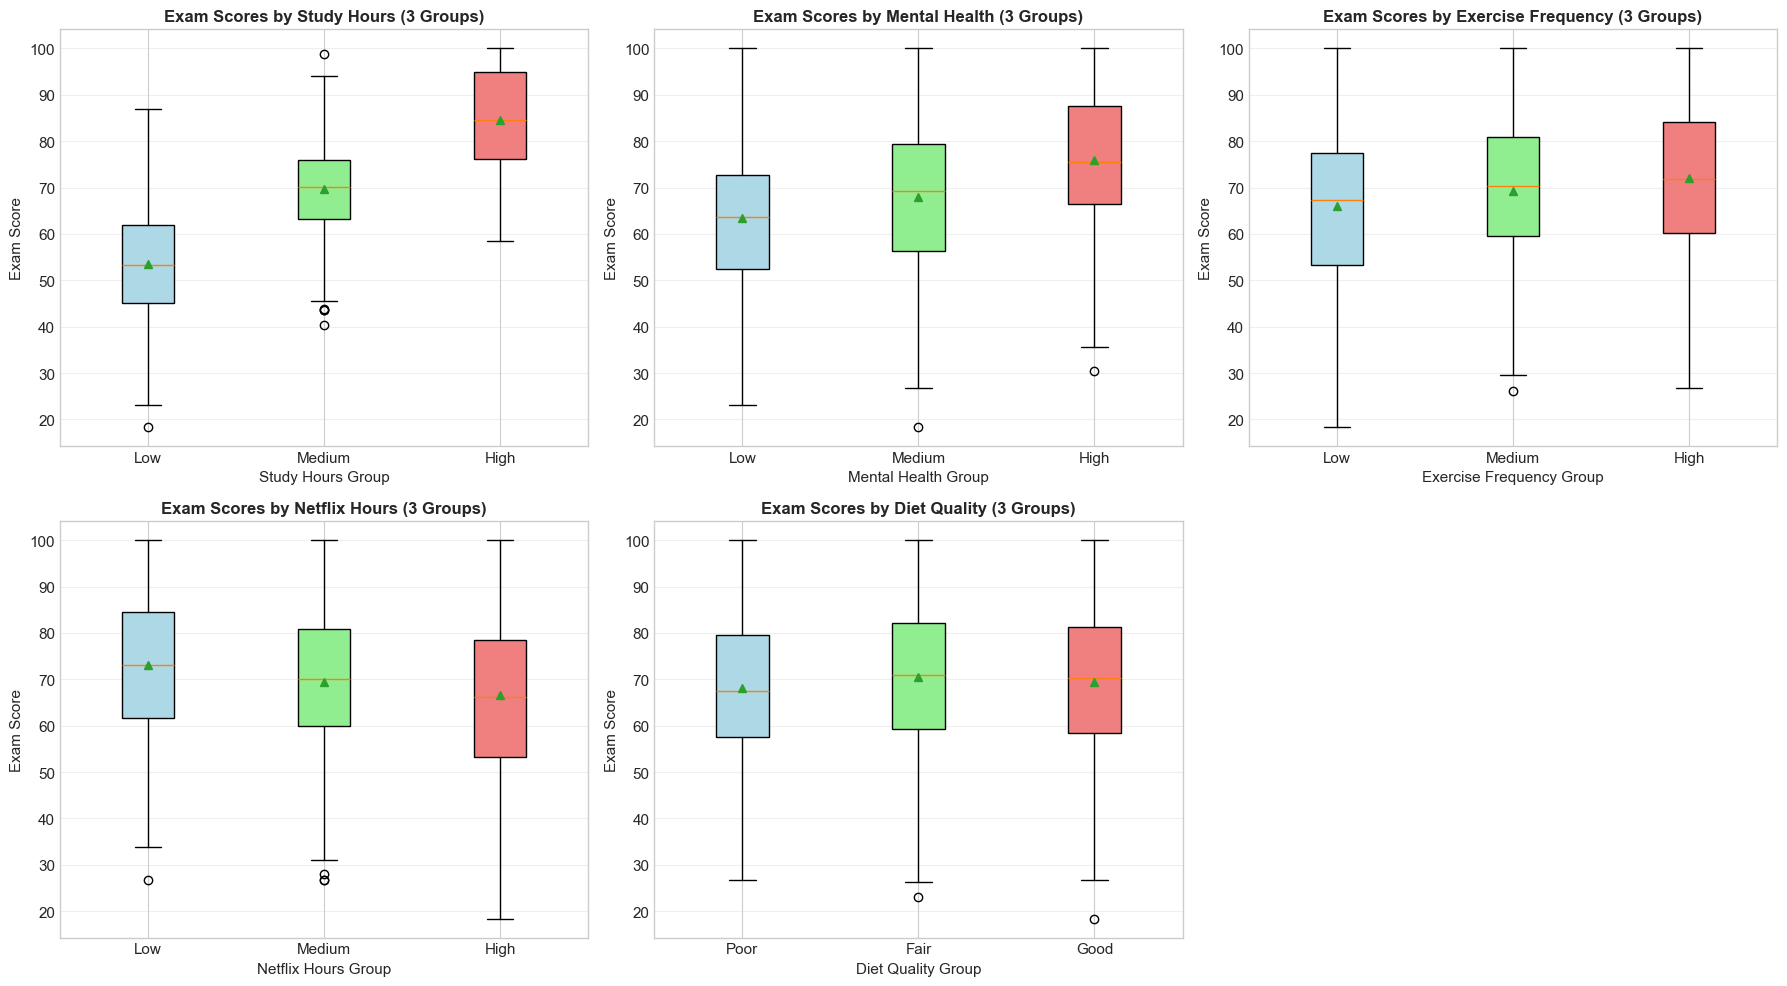

In [417]:
# Create comparison plots for all ANOVA analyses
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

colors = ['lightblue', 'lightgreen', 'lightcoral']

# Study hours ANOVA visualization
boxData1 = [lowStudy, medStudy, highStudy]
bp1 = axes[0, 0].boxplot(boxData1, labels=['Low', 'Medium', 'High'],
                       patch_artist=True, showmeans=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 0].set_xlabel('Study Hours Group', fontsize=11)
axes[0, 0].set_ylabel('Exam Score', fontsize=11)
axes[0, 0].set_title('Exam Scores by Study Hours (3 Groups)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Mental health ANOVA visualization
boxData2 = [lowMental, medMental, highMental]
bp2 = axes[0, 1].boxplot(boxData2, labels=['Low', 'Medium', 'High'],
                       patch_artist=True, showmeans=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 1].set_xlabel('Mental Health Group', fontsize=11)
axes[0, 1].set_ylabel('Exam Score', fontsize=11)
axes[0, 1].set_title('Exam Scores by Mental Health (3 Groups)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Exercise frequency ANOVA visualization
boxData3 = [lowExercise, medExercise, highExercise]
bp3 = axes[0, 2].boxplot(boxData3, labels=['Low', 'Medium', 'High'],
                       patch_artist=True, showmeans=True)
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
axes[0, 2].set_xlabel('Exercise Frequency Group', fontsize=11)
axes[0, 2].set_ylabel('Exam Score', fontsize=11)
axes[0, 2].set_title('Exam Scores by Exercise Frequency (3 Groups)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Netflix hours ANOVA visualization
boxData4 = [lowNetflix, medNetflix, highNetflix]
bp4 = axes[1, 0].boxplot(boxData4, labels=['Low', 'Medium', 'High'],
                       patch_artist=True, showmeans=True)
for patch, color in zip(bp4['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 0].set_xlabel('Netflix Hours Group', fontsize=11)
axes[1, 0].set_ylabel('Exam Score', fontsize=11)
axes[1, 0].set_title('Exam Scores by Netflix Hours (3 Groups)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Diet quality ANOVA visualization
boxData5 = [poorDiet, fairDiet, goodDiet]
bp5 = axes[1, 1].boxplot(boxData5, labels=['Poor', 'Fair', 'Good'],
                       patch_artist=True, showmeans=True)
for patch, color in zip(bp5['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 1].set_xlabel('Diet Quality Group', fontsize=11)
axes[1, 1].set_ylabel('Exam Score', fontsize=11)
axes[1, 1].set_title('Exam Scores by Diet Quality (3 Groups)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Remove the extra subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

## 5.7 Chi-Squared Tests for Categorical Associations

Examining relationships between exam performance categories and categorical variables.

In [430]:
# Create exam performance categories (tertiles to match ANOVA grouping)
examQ1 = df['exam_score'].quantile(0.33)
examQ2 = df['exam_score'].quantile(0.67)
df['examPerformance'] = df['exam_score'].apply(
    lambda x: 'Low' if x < examQ1 else ('Medium' if x < examQ2 else 'High')
)

print("Exam Performance Category Distribution:")
print(df['examPerformance'].value_counts().sort_index())
print(f"\nCutoff scores:")
print(f"Low: < {examQ1:.2f}")
print(f"Medium: {examQ1:.2f} - {examQ2:.2f}")
print(f"High: > {examQ2:.2f}")

Exam Performance Category Distribution:
examPerformance
High      330
Low       329
Medium    341
Name: count, dtype: int64

Cutoff scores:
Low: < 62.70
Medium: 62.70 - 77.03
High: > 77.03


### 5.7.1 Exam Performance × Parental Education Level

**Hypotheses:**
- H₀: Exam performance is independent of parental education level
- H₁: Exam performance is associated with parental education level

In [419]:
# Create contingency table
contingencyTable1 = pd.crosstab(df['examPerformance'], df['parental_education_level'])

print("Contingency Table: Exam Performance × Parental Education Level")
print(contingencyTable1)
print(f"\nTotal observations: {contingencyTable1.sum().sum()}")

Contingency Table: Exam Performance × Parental Education Level
parental_education_level  Bachelor  High School  Master  None
examPerformance                                              
High                           120          134      47    29
Low                            106          134      60    29
Medium                         124          124      60    33

Total observations: 1000


In [420]:
from scipy.stats import chi2_contingency

# Perform Chi-squared test
chi2Stat, pValue, dof, expectedFreq = chi2_contingency(contingencyTable1)

print("Chi-Squared Test Results:")
print(f"Chi-squared statistic: {chi2Stat:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {pValue:.4e}")
print(f"Significance: {'Significant' if pValue < 0.05 else 'Not Significant'} at α = 0.05")

# Calculate Cramér's V (effect size)
n = contingencyTable1.sum().sum()
minDim = min(contingencyTable1.shape[0] - 1, contingencyTable1.shape[1] - 1)
cramersV = np.sqrt(chi2Stat / (n * minDim))

print(f"\nEffect Size (Cramér's V): {cramersV:.4f}")
if cramersV < 0.1:
    effect = "negligible"
elif cramersV < 0.3:
    effect = "small"
elif cramersV < 0.5:
    effect = "medium"
else:
    effect = "large"
print(f"Interpretation: {effect.capitalize()} effect")

Chi-Squared Test Results:
Chi-squared statistic: 4.1585
Degrees of freedom: 6
p-value: 6.5524e-01
Significance: Not Significant at α = 0.05

Effect Size (Cramér's V): 0.0456
Interpretation: Negligible effect


In [421]:
# Display expected frequencies
print("\nExpected Frequencies:")
expectedDf = pd.DataFrame(expectedFreq, 
                          index=contingencyTable1.index,
                          columns=contingencyTable1.columns)
print(expectedDf.round(2))

# Check assumption: all expected frequencies >= 5
minExpected = expectedFreq.min()
print(f"\nMinimum expected frequency: {minExpected:.2f}")
if minExpected >= 5:
    print("Assumption satisfied: All expected frequencies ≥ 5")
else:
    print("Warning: Some expected frequencies < 5; results may be unreliable")


Expected Frequencies:
parental_education_level  Bachelor  High School  Master   None
examPerformance                                               
High                        115.50       129.36   55.11  30.03
Low                         115.15       128.97   54.94  29.94
Medium                      119.35       133.67   56.95  31.03

Minimum expected frequency: 29.94
Assumption satisfied: All expected frequencies ≥ 5


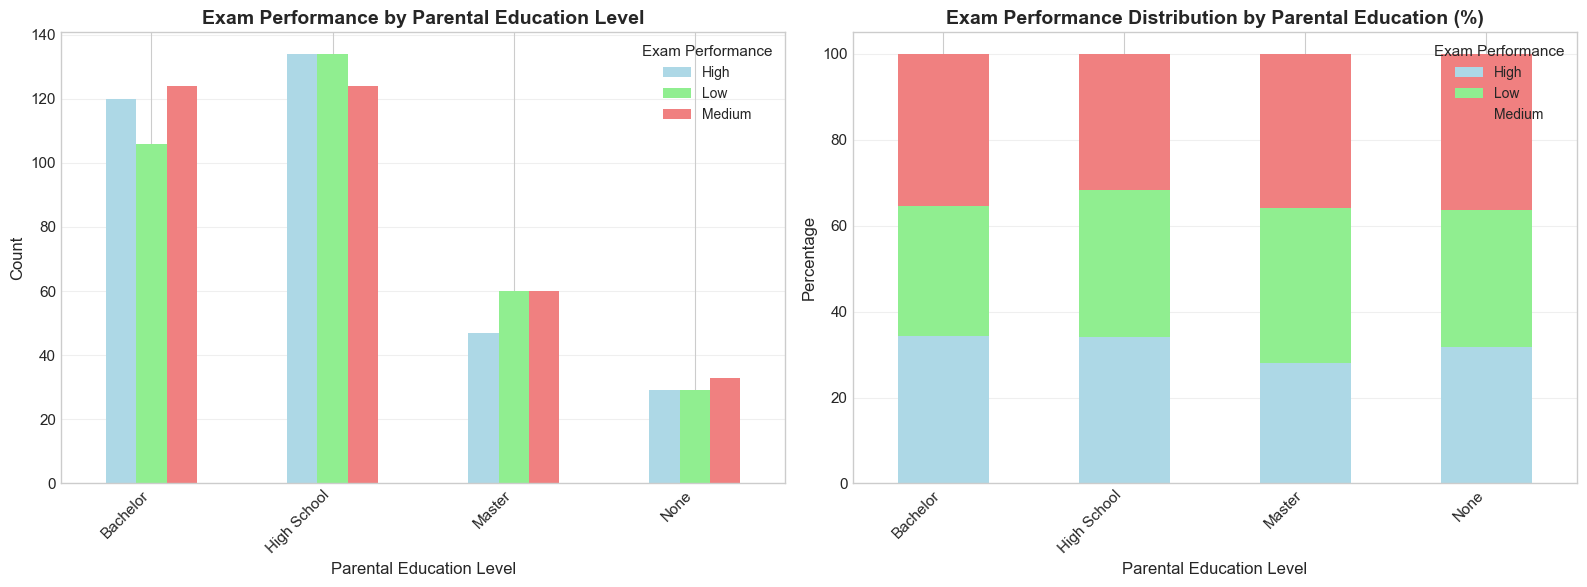

In [422]:
# Visualize with grouped bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grouped bar chart
contingencyTable1.T.plot(kind='bar', ax=axes[0], color=['lightblue', 'lightgreen', 'lightcoral'])
axes[0].set_xlabel('Parental Education Level', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Exam Performance by Parental Education Level', fontsize=14, fontweight='bold')
axes[0].legend(title='Exam Performance', title_fontsize=11, fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Stacked percentage bar chart
contingencyPct1 = contingencyTable1.T.div(contingencyTable1.T.sum(axis=1), axis=0) * 100
contingencyPct1.plot(kind='bar', stacked=True, ax=axes[1], 
                      color=['lightblue', 'lightgreen', 'lightcoral'])
axes[1].set_xlabel('Parental Education Level', fontsize=12)
axes[1].set_ylabel('Percentage', fontsize=12)
axes[1].set_title('Exam Performance Distribution by Parental Education (%)', fontsize=14, fontweight='bold')
axes[1].legend(title='Exam Performance', title_fontsize=11, fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### 5.7.2 Exam Performance × Diet Quality

**Hypotheses:**
- H₀: Exam performance is independent of diet quality
- H₁: Exam performance is associated with diet quality

In [423]:
# Create contingency table
contingencyTable2 = pd.crosstab(df['examPerformance'], df['diet_quality'])

print("Contingency Table: Exam Performance × Diet Quality")
print(contingencyTable2)
print(f"\nTotal observations: {contingencyTable2.sum().sum()}")

Contingency Table: Exam Performance × Diet Quality
diet_quality     Fair  Good  Poor
examPerformance                  
High              152   122    56
Low               143   121    65
Medium            142   135    64

Total observations: 1000


In [424]:
# Perform Chi-squared test
chi2Stat, pValue, dof, expectedFreq = chi2_contingency(contingencyTable2)

print("Chi-Squared Test Results:")
print(f"Chi-squared statistic: {chi2Stat:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {pValue:.4e}")
print(f"Significance: {'Significant' if pValue < 0.05 else 'Not Significant'} at α = 0.05")

# Calculate Cramér's V (effect size)
n = contingencyTable2.sum().sum()
minDim = min(contingencyTable2.shape[0] - 1, contingencyTable2.shape[1] - 1)
cramersV = np.sqrt(chi2Stat / (n * minDim))

print(f"\nEffect Size (Cramér's V): {cramersV:.4f}")
if cramersV < 0.1:
    effect = "negligible"
elif cramersV < 0.3:
    effect = "small"
elif cramersV < 0.5:
    effect = "medium"
else:
    effect = "large"
print(f"Interpretation: {effect.capitalize()} effect")

Chi-Squared Test Results:
Chi-squared statistic: 1.9072
Degrees of freedom: 4
p-value: 7.5281e-01
Significance: Not Significant at α = 0.05

Effect Size (Cramér's V): 0.0309
Interpretation: Negligible effect


In [425]:
# Display expected frequencies
print("\nExpected Frequencies:")
expectedDf = pd.DataFrame(expectedFreq, 
                          index=contingencyTable2.index,
                          columns=contingencyTable2.columns)
print(expectedDf.round(2))

# Check assumption: all expected frequencies >= 5
minExpected = expectedFreq.min()
print(f"\nMinimum expected frequency: {minExpected:.2f}")
if minExpected >= 5:
    print("Assumption satisfied: All expected frequencies ≥ 5")
else:
    print("Warning: Some expected frequencies < 5; results may be unreliable")


Expected Frequencies:
diet_quality       Fair    Good   Poor
examPerformance                       
High             144.21  124.74  61.05
Low              143.77  124.36  60.86
Medium           149.02  128.90  63.08

Minimum expected frequency: 60.87
Assumption satisfied: All expected frequencies ≥ 5


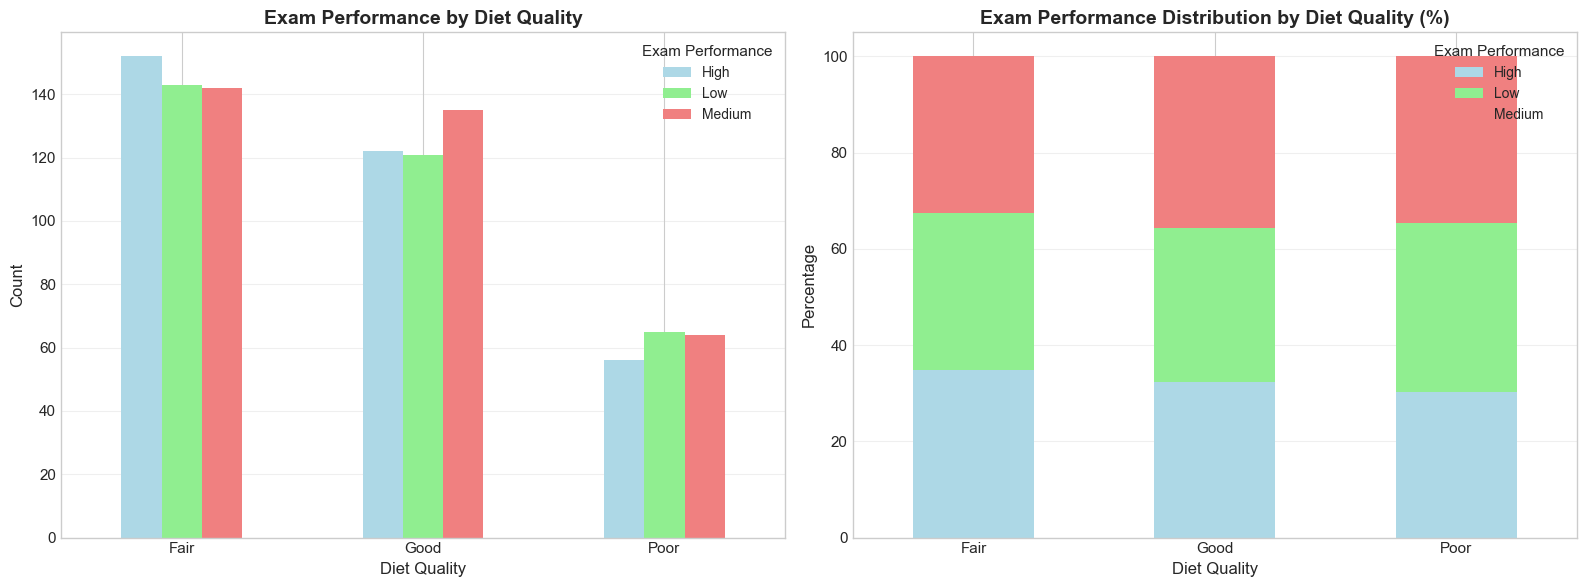

In [426]:
# Visualize with grouped bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grouped bar chart
contingencyTable2.T.plot(kind='bar', ax=axes[0], color=['lightblue', 'lightgreen', 'lightcoral'])
axes[0].set_xlabel('Diet Quality', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Exam Performance by Diet Quality', fontsize=14, fontweight='bold')
axes[0].legend(title='Exam Performance', title_fontsize=11, fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)

# Stacked percentage bar chart
contingencyPct2 = contingencyTable2.T.div(contingencyTable2.T.sum(axis=1), axis=0) * 100
contingencyPct2.plot(kind='bar', stacked=True, ax=axes[1], 
                      color=['lightblue', 'lightgreen', 'lightcoral'])
axes[1].set_xlabel('Diet Quality', fontsize=12)
axes[1].set_ylabel('Percentage', fontsize=12)
axes[1].set_title('Exam Performance Distribution by Diet Quality (%)', fontsize=14, fontweight='bold')
axes[1].legend(title='Exam Performance', title_fontsize=11, fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

### 5.8 Visualization of Chi-Squared Test Results

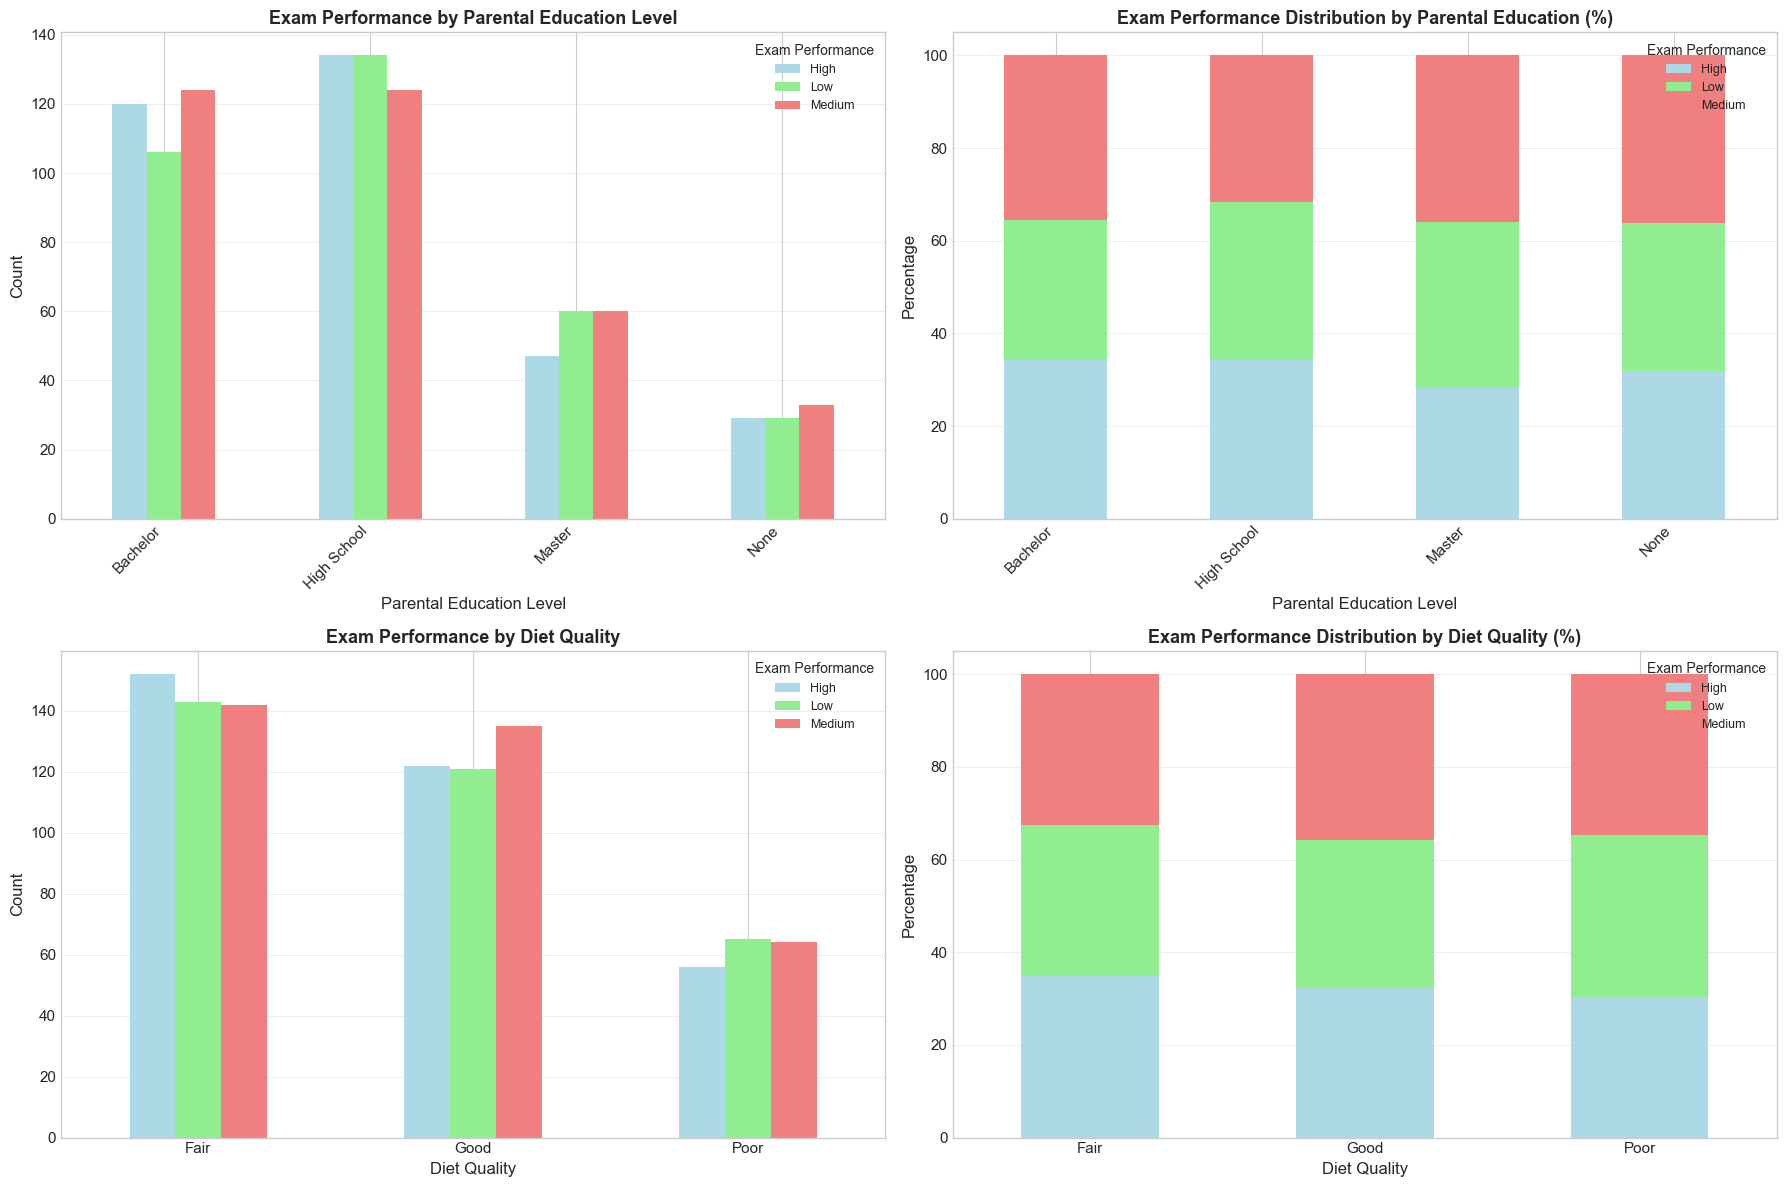

In [427]:
# Create unified visualization for both chi-squared tests
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Recreate contingency tables for visualization
contingencyTable1 = pd.crosstab(df['examPerformance'], df['parental_education_level'])
contingencyTable2 = pd.crosstab(df['examPerformance'], df['diet_quality'])

# Calculate percentages
contingencyPct1 = contingencyTable1.T.div(contingencyTable1.T.sum(axis=1), axis=0) * 100
contingencyPct2 = contingencyTable2.T.div(contingencyTable2.T.sum(axis=1), axis=0) * 100

# Row 1: Parental Education Level
# Grouped bar chart
contingencyTable1.T.plot(kind='bar', ax=axes[0, 0], 
                          color=['lightblue', 'lightgreen', 'lightcoral'])
axes[0, 0].set_xlabel('Parental Education Level', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].set_title('Exam Performance by Parental Education Level', 
                      fontsize=13, fontweight='bold')
axes[0, 0].legend(title='Exam Performance', title_fontsize=10, fontsize=9)
axes[0, 0].grid(True, alpha=0.3, axis='y')
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Stacked percentage bar chart
contingencyPct1.plot(kind='bar', stacked=True, ax=axes[0, 1],
                      color=['lightblue', 'lightgreen', 'lightcoral'])
axes[0, 1].set_xlabel('Parental Education Level', fontsize=12)
axes[0, 1].set_ylabel('Percentage', fontsize=12)
axes[0, 1].set_title('Exam Performance Distribution by Parental Education (%)', 
                      fontsize=13, fontweight='bold')
axes[0, 1].legend(title='Exam Performance', title_fontsize=10, fontsize=9)
axes[0, 1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Row 2: Diet Quality
# Grouped bar chart
contingencyTable2.T.plot(kind='bar', ax=axes[1, 0],
                          color=['lightblue', 'lightgreen', 'lightcoral'])
axes[1, 0].set_xlabel('Diet Quality', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)
axes[1, 0].set_title('Exam Performance by Diet Quality', 
                      fontsize=13, fontweight='bold')
axes[1, 0].legend(title='Exam Performance', title_fontsize=10, fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=0)

# Stacked percentage bar chart  
contingencyPct2.plot(kind='bar', stacked=True, ax=axes[1, 1],
                      color=['lightblue', 'lightgreen', 'lightcoral'])
axes[1, 1].set_xlabel('Diet Quality', fontsize=12)
axes[1, 1].set_ylabel('Percentage', fontsize=12)
axes[1, 1].set_title('Exam Performance Distribution by Diet Quality (%)', 
                      fontsize=13, fontweight='bold')
axes[1, 1].legend(title='Exam Performance', title_fontsize=10, fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## 6. Summary and Conclusions

In [428]:
# Recalculate for summary
tStat1, pValue1 = ttest_ind(highStudyScores, lowStudyScores)
tStat2, pValue2 = ttest_ind(higherMentalScores, lowerMentalScores)

print("GROUP COMPARISON ANALYSIS SUMMARY\n")

print("T-TEST RESULTS (2 Groups)")

print("1. Study Hours Groups:")
print(f"   Low Study Hours: M = {lowStudyScores.mean():.2f}, SD = {lowStudyScores.std():.2f}")
print(f"   High Study Hours: M = {highStudyScores.mean():.2f}, SD = {highStudyScores.std():.2f}")
print(f"   t = {tStat1:.2f}, p = {pValue1:.4f}")
print(f"   Result: {'Significant' if pValue1 < 0.05 else 'Not Significant'}\n")

print("2. Mental Health Groups:")
print(f"   Lower Mental Health: M = {lowerMentalScores.mean():.2f}, SD = {lowerMentalScores.std():.2f}")
print(f"   Higher Mental Health: M = {higherMentalScores.mean():.2f}, SD = {higherMentalScores.std():.2f}")
print(f"   t = {tStat2:.2f}, p = {pValue2:.4f}")
print(f"   Result: {'Significant' if pValue2 < 0.05 else 'Not Significant'}\n")

print("ANOVA RESULTS (3 Groups)")

# Recalculate for summary
fStat1, pValue1 = f_oneway(lowStudy, medStudy, highStudy)
fStat2, pValue2 = f_oneway(lowMental, medMental, highMental)
fStat3, pValue3 = f_oneway(lowExercise, medExercise, highExercise)
fStat4, pValue4 = f_oneway(lowNetflix, medNetflix, highNetflix)
fStat5, pValue5 = f_oneway(poorDiet, fairDiet, goodDiet)

print("1. Study Hours Groups:")
print(f"   Low: M = {lowStudy.mean():.2f}, SD = {lowStudy.std():.2f}")
print(f"   Medium: M = {medStudy.mean():.2f}, SD = {medStudy.std():.2f}")
print(f"   High: M = {highStudy.mean():.2f}, SD = {highStudy.std():.2f}")
print(f"   F = {fStat1:.2f}, p = {pValue1:.4f}")
print(f"   Result: {'Significant' if pValue1 < 0.05 else 'Not Significant'}\n")

print("2. Mental Health Groups:")
print(f"   Low: M = {lowMental.mean():.2f}, SD = {lowMental.std():.2f}")
print(f"   Medium: M = {medMental.mean():.2f}, SD = {medMental.std():.2f}")
print(f"   High: M = {highMental.mean():.2f}, SD = {highMental.std():.2f}")
print(f"   F = {fStat2:.2f}, p = {pValue2:.4f}")
print(f"   Result: {'Significant' if pValue2 < 0.05 else 'Not Significant'}\n")

print("3. Exercise Frequency Groups:")
print(f"   Low: M = {lowExercise.mean():.2f}, SD = {lowExercise.std():.2f}")
print(f"   Medium: M = {medExercise.mean():.2f}, SD = {medExercise.std():.2f}")
print(f"   High: M = {highExercise.mean():.2f}, SD = {highExercise.std():.2f}")
print(f"   F = {fStat3:.2f}, p = {pValue3:.4f}")
print(f"   Result: {'Significant' if pValue3 < 0.05 else 'Not Significant'}\n")

print("4. Netflix Hours Groups:")
print(f"   Low: M = {lowNetflix.mean():.2f}, SD = {lowNetflix.std():.2f}")
print(f"   Medium: M = {medNetflix.mean():.2f}, SD = {medNetflix.std():.2f}")
print(f"   High: M = {highNetflix.mean():.2f}, SD = {highNetflix.std():.2f}")
print(f"   F = {fStat4:.2f}, p = {pValue4:.4f}")
print(f"   Result: {'Significant' if pValue4 < 0.05 else 'Not Significant'}\n")

print("5. Diet Quality Groups:")
print(f"   Poor: M = {poorDiet.mean():.2f}, SD = {poorDiet.std():.2f}")
print(f"   Fair: M = {fairDiet.mean():.2f}, SD = {fairDiet.std():.2f}")
print(f"   Good: M = {goodDiet.mean():.2f}, SD = {goodDiet.std():.2f}")
print(f"   F = {fStat5:.2f}, p = {pValue5:.4f}")
print(f"   Result: {'Significant' if pValue5 < 0.05 else 'Not Significant'}\n")

print("CHI-SQUARED TEST RESULTS (Categorical Associations)")

# Recalculate Chi-squared tests for summary
from scipy.stats import chi2_contingency

contingencyTable1 = pd.crosstab(df['examPerformance'], df['parental_education_level'])
chi2Stat1, pValue1, dof1, _ = chi2_contingency(contingencyTable1)
n1 = contingencyTable1.sum().sum()
minDim1 = min(contingencyTable1.shape[0] - 1, contingencyTable1.shape[1] - 1)
cramersV1 = np.sqrt(chi2Stat1 / (n1 * minDim1))

contingencyTable2 = pd.crosstab(df['examPerformance'], df['diet_quality'])
chi2Stat2, pValue2, dof2, _ = chi2_contingency(contingencyTable2)
n2 = contingencyTable2.sum().sum()
minDim2 = min(contingencyTable2.shape[0] - 1, contingencyTable2.shape[1] - 1)
cramersV2 = np.sqrt(chi2Stat2 / (n2 * minDim2))

print("\n1. Exam Performance × Parental Education Level:")
print(f"   χ² = {chi2Stat1:.2f}, df = {dof1}, p = {pValue1:.4f}")
print(f"   Cramér's V = {cramersV1:.4f}")
print(f"   Result: {'Significant' if pValue1 < 0.05 else 'Not Significant'}")

print("\n2. Exam Performance × Diet Quality:")
print(f"   χ² = {chi2Stat2:.2f}, df = {dof2}, p = {pValue2:.4f}")
print(f"   Cramér's V = {cramersV2:.4f}")
print(f"   Result: {'Significant' if pValue2 < 0.05 else 'Not Significant'}")


GROUP COMPARISON ANALYSIS SUMMARY

T-TEST RESULTS (2 Groups)
1. Study Hours Groups:
   Low Study Hours: M = 57.81, SD = 13.28
   High Study Hours: M = 80.10, SD = 12.17
   t = 27.71, p = 0.0000
   Result: Significant

2. Mental Health Groups:
   Lower Mental Health: M = 64.03, SD = 16.39
   Higher Mental Health: M = 73.49, SD = 16.14
   t = 9.05, p = 0.0000
   Result: Significant

ANOVA RESULTS (3 Groups)
1. Study Hours Groups:
   Low: M = 53.45, SD = 12.40
   Medium: M = 69.64, SD = 10.15
   High: M = 84.52, SD = 11.38
   F = 614.67, p = 0.0000
   Result: Significant

2. Mental Health Groups:
   Low: M = 63.43, SD = 15.94
   Medium: M = 67.87, SD = 16.85
   High: M = 75.90, SD = 15.49
   F = 53.43, p = 0.0000
   Result: Significant

3. Exercise Frequency Groups:
   Low: M = 66.09, SD = 16.97
   Medium: M = 69.30, SD = 15.91
   High: M = 72.13, SD = 17.04
   F = 11.44, p = 0.0000
   Result: Significant

4. Netflix Hours Groups:
   Low: M = 73.14, SD = 15.93
   Medium: M = 69.40, SD = 1